<center><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQXnrruP7guibF61c4gOESBR2VhhqYmEjKin0yY9lrhCak3hIbXI0QDSlObO74xcBkjMw&usqp=CAU"/></center>

# 🔍 Build a nest - AGRIF 

<small>
This notebook allows you to build a child grid/a nest from a parent grid (created with <strong>`make_grid.ipynb`</strong>) with offline or AGRIF methods
<br>💡 It is linked to the croco-ocean/croco_pytools' <a href= "https://gitlab.inria.fr/croco-ocean/croco_pytools/-/issues/4">ISSUE #4</a> located on the <strong>croco-ocean INRIA's gitlab</strong>
<br>➡️ Notebook created by <a href="mailto:thibault.delahaye@ird.fr">Thibault Delahaye</a> and based on the existing codes of pycrocotool
<br>🌳 Developped on **notebook-grid-tools**'s branch, whose source is the main branch
</small>

## 📖-Code-presentation

### Method

<div class="alert alert-block alert-info">

To represent fine-scale phenomena, CROCO offers the ability to create zooms with increased resolution. Two options exist 🛠️:  
    
##### Offline Zoom 🗺️ ➡️ 🔍

- **Description**: Creation of a grid with the desired resolution, where the boundaries are within a grid of a larger CROCO domain, already modeled.
- **Conditions**: The high-resolution grid takes as initial and boundary conditions those from the larger CROCO simulation. The simulations are independent and no feedback from the high-resolution grid to the coarser grid is possible. The simulations run separately.
- **Advantages**:
  - Independence
  - No constraints on the chosen resolution
- **Disadvantages**:
  - No feedback to the larger domain
  - Zoom boundary forcing depends on the frequency of the parent grid’s history, which may filter out some waves present in the parent grid.

<div style="border: 2px dotted black; padding: 10px; margin: 10px;">

##### AGRIF Zoom 🔄

- **Description**: AGRIF is a library that allows running CROCO with several embedded domains together. (see documentation in CROCO documentation)
- **Conditions**: Parent and child(s) domains are run simultaneously, coupling the domains at the barotropic time step.
- **Advantages**:
  - Two-way feedback to the parent domain is possible and can significantly improve results of the larger domain
  - Coupling at the highest possible frequency
  - Consistency of numerics
  - Any number of nesting levels is allowed
- **Disadvantages**:
  - Requires simultaneous execution of the parent and child(s) grids
  - Nesting ratio should be 3 or 5
  - Currently, AGRIF zooms in CROCO must have the same vertical resolution as the parent.
</div>

</div>

### 💾 Datasets

Further Information: [CROCO OCEAN WEBSITE](http://www.croco-ocean.org)
  
*This file is part of CROCOTOOLS* 🐊

**Create a CROCO grid file** 🌐   
In the current state the script can handle:  

<table style="width: 100%; text-align: left; border-collapse: collapse;">
  <thead>
    <tr>
      <th style="border: 1px solid #ddd; padding: 8px; background-color: #f4f4f4;">DATA</th>
      <th style="border: 1px solid #ddd; padding: 8px; background-color: #f4f4f4;">SOURCE</th>
      <th style="border: 1px solid #ddd; padding: 8px; background-color: #f4f4f4;">FILE EXTENSION</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;"><strong>⛰️ topo/bathy</strong></td>
      <td style="border: 1px solid #ddd; padding: 8px;">etopo (5,2,1),<br>srtm30, gebco</td>
      <td style="border: 1px solid #ddd; padding: 8px;"><em>NetCDF</em></td>
    </tr>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;"><strong>🏖️ coastline</strong></td>
      <td style="border: 1px solid #ddd; padding: 8px;">GSHHS</td>
      <td style="border: 1px solid #ddd; padding: 8px;"><em>shapefile</em></td>
    </tr>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;"><strong>🐊 parent CROCO grid</strong></td>
      <td style="border: 1px solid #ddd; padding: 8px;">croco_grd built with make_grid.ipynb</td>
      <td style="border: 1px solid #ddd; padding: 8px;"><em>NetCDF</em></td>
    </tr>
  </tbody>
</table>

### ⚙️ Requirements
➡️ Installing `ipympl` for interactive Plots :

*To use **interactive plotting** features with the `%matplotlib widget` [magic command](#Magic-cells) in Jupyter Notebook or JupyterLab, you need to install the `ipympl` package. This package enables Matplotlib to render interactive plots using Jupyter widgets.*

 **Run the following command** in a code cell or in your notebook to install `ipympl`:
   ```python
   pip install ipympl
   ```

---

<div style="text-align: center; font-size: 0.9em; color: gray;">
  CODE BODY
</div>

---

### Magic cells

[Magic cell](https://ipython.readthedocs.io/en/stable/interactive/magics.html) ⚡🐚 dedicated to the activation of backend environments

In [1]:
#Allows widget interactivity with user
%matplotlib widget    
%load_ext autoreload
%autoreload 2

### Dependencies

In [55]:
import numpy as np
import os,sys
os.environ['ETS_TOOLKIT'] = 'wx'
sys.path.append("./Modules/")
sys.path.append("./Readers/")
sys.path.append("./Modules/graphicUI_tools/")
from main_window import *
import tools_make_grid
#----------------------------------------------#
from tools_make_grid import GetMask,GetTopo, topo_prt, Inputs_smth_c2c, Inputs_c2c
from croco_class import CROCO
from main_window import Outputs
#----------------------------------------------#
from Modules.map_tools.map_tools import plot_grid, plot_outline, plot_topo
from scipy.spatial import distance
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact_manual
#----------------------------------------------#
from matplotlib.widgets import RectangleSelector
from ipywidgets import FloatText, VBox
from IPython.display import display, clear_output

## 🗺️ Parent grid path and infos

### Parent grid path:

In [3]:
parent_grid_file= "../../CROCO_FILES/croco_grd.nc"

### Collecting parent's grid inputs/outputs parameters

#### Collecting parent's grid outputs

In [63]:
prt= topo_prt(parent_grid_file)

## 🐣 Build the nest

<div class="alert alert-block alert-info">
    
**AGRIF (Adaptive Grid Refinement in Fortran)** is a Fortran 95 package for the inclusion of adaptive mesh refinement features within a finite difference numerical model. One of the major advantages of AGRIF in static-grid embedding is the ability to manage an arbitrary number of fixed grids and an arbitrary number of embedding levels.  

</div>

### Nested Grids Explanation (example for a 1:3 refinement ratio )

The nested grids are rectangular and are aligned with the parent (coarser) grid within which they are nested.

- **$i_{\text{min}}$, $i_{\text{max}}$, $j_{\text{min}}$, and $j_{\text{max}}$** refer to the positions of the child grid corners, in terms of its parent grid starting with the value 1 in each space direction.
- When the user chooses these positions, one has to take care that the fine grid is contained within the parent grid.
- **$(i_{\text{min}}, j_{\text{min}})$** are the lower left corner positions and **$(i_{\text{max}}, j_{\text{max}})$** are the upper right corner positions.

This is a quite important feature to know in order to properly choose integers **$i_{\text{min}}$, $i_{\text{max}}$, $j_{\text{min}}$, and $j_{\text{max}}$** for your fine grid domain definition. Indeed, the index of the first coarse grid point inside the child domain is _($i_{\text{min}} + 2$, $j_{\text{min}} + 2$)_ and not _($i_{\text{min}}$, $j_{\text{min}}$)_.

<div style="display: flex; align-items: flex-start; justify-content: space-between; margin-top: 20px;">
    <div style="flex: 1; max-width: 50%; margin-right: 20px;">
        <p>
            The nested grids are rectangular and are aligned with the parent (coarser) grid within which they are nested. 
            <br><br>
            - $i_{\text{min}}$, $i_{\text{max}}$, $j_{\text{min}}$, and $j_{\text{max}}$ refer to the positions of the child grid corners, in terms of its parent grid starting with the value 1 in each space direction.
            <br>
            - When the user chooses these positions, one has to take care that the fine grid is contained within the parent grid.
            <br>
            - $(i_{\text{min}}, j_{\text{min}})$ are the lower left corner positions and $(i_{\text{max}}, j_{\text{max}})$ are the upper right corner positions.
            <br><br>
            This is a quite important feature to know in order to properly choose integers $i_{\text{min}}$, $i_{\text{max}}$, $j_{\text{min}}$, and $j_{\text{max}}$ for your fine grid domain definition. Indeed, the index of the first coarse grid point inside the child domain is _($i_{\text{min}} + 2$, $j_{\text{min}} + 2$)_ and not _($i_{\text{min}}$, $j_{\text{min}}$)_.
        </p>
    </div>
    <div style="flex: 1; max-width: 50%;">
        <img src="http://forge.ipsl.jussieu.fr/nemo/raw-attachment/wiki/Users/SetupNewConfiguration/AGRIF-nesting-tool/AGRIF-Grid-Definition.jpg" alt="AGRIF Grid Definition" style="width: 90%; height: auto; display: block; margin-left: auto; margin-right: auto;">
    </div>
</div>



### Create a new child grid

#### ✏️🔧 User's changes

##### AGRIF grid parameters

In [15]:
#Refinement coefficient
coef= 3 

#Child grid corners positions on the parent grid
imin= 10
imax= 27
jmin= 8
jmax= 28

#### Smoothing settings

See [online documentation](https://croco-ocean.gitlabpages.inria.fr/croco_doc/model/model.grid.html) for more details 📚

In [57]:
interp_rad  = 2     # Interpolation radius in number of points (usually between 2 and 8)
rfact       = 0.2   # Maximum r-fact to reach (the lower it is, the smoother it will be)    
smooth_meth = 'lsmooth' # Smoothing method ('smooth', 'lsmooth', 'lsmooth_legacy', 'lsmooth2', 'lsmooth1', 'cond_rx0_topo') 

##### Paths

###### Inputs

Topo/bathy file ⛰️ :

In [16]:
topofile = '../../DATASETS_CROCOTOOLS/Topo/etopo2.nc'

Coastline file (for the mask) 🏖️ :

In [17]:
shp_file = '../../DATASETS_CROCOTOOLS/gshhs/GSHHS_shp/i/GSHHS_i_L1.shp'

###### Output(s)

Output directory:

In [18]:
output_file="../../CROCO_FILES/"

##### Mask

Single Connect (Masks water not connected to the main water body) 🎭:

In [19]:
sgl_connect=[False,20,20] # True or False, point indices inside the main water body

##### Open boundary conditions

<div style="border: 2px solid yellow; padding: 10px; background-color: #fff3e0;">
    <strong>🚨 CHECKBOX SELECTION:</strong> SIMPLY RUN THE NEXT CELL TO SELECT OBCs
</div>

###### Run widget

In [24]:
# Define variables to store the settings
settings = {
    'NORTH': True,
    'SOUTH': True,
    'WEST': True,
    'EAST': True,
    'MERGING_AREA': 5  # Set default value to 5
}

# Function to handle saving values
def save_values(b):
    # Update settings with current values
    settings['NORTH'] = north_checkbox.value
    settings['SOUTH'] = south_checkbox.value
    settings['WEST'] = west_checkbox.value
    settings['EAST'] = east_checkbox.value
    settings['MERGING_AREA'] = merging_area_text.value
    
    # Display confirmation message
    with output:
        clear_output()
        print("Settings have been saved.")
        print(settings)  # Display current settings for verification

# Create checkboxes for each border
north_checkbox = widgets.Checkbox(value=settings['NORTH'], description='North Border ⬆️')
south_checkbox = widgets.Checkbox(value=settings['SOUTH'], description='South Border ⬇️')
west_checkbox = widgets.Checkbox(value=settings['WEST'], description='West Border ⬅️')
east_checkbox = widgets.Checkbox(value=settings['EAST'], description='East Border ➡️')

# Create a field for the "Merging Area" parameter as an integer with default value 5
merging_area_text = widgets.IntText(
    value=settings['MERGING_AREA'], 
    layout=widgets.Layout(width='100px')  # Adjust width of the input field
)
merging_area_label = widgets.Label(
    value='Merging Area:', 
    layout=widgets.Layout(width='150px', display='flex', justify_content='flex-end')  # Adjust label width and alignment
)

# Create an HBox for the label and input field
merging_area_box = widgets.HBox(children=[
    merging_area_label, 
    merging_area_text
])

# Create a button to save the settings
save_button = widgets.Button(description="Save Settings")
save_button.on_click(save_values)

# Create a box around the widgets with custom styling
border_box = widgets.VBox(children=[
    north_checkbox, 
    south_checkbox, 
    west_checkbox, 
    east_checkbox,
    merging_area_box,
    save_button
])

# Apply CSS styles to the box
border_box.layout.border = '2px solid #007bff'
border_box.layout.padding = '10px'
border_box.layout.border_radius = '5px'
border_box.layout.margin = '10px'
border_box.layout.width = '400px'  # Increase width to ensure full visibility

# Adjust width of individual widgets
north_checkbox.layout.width = '100%'
south_checkbox.layout.width = '100%'
west_checkbox.layout.width = '100%'
east_checkbox.layout.width = '100%'
merging_area_text.layout.width = '100px'  # Set a specific width for the input field

# Create an output area for displaying messages
output = widgets.Output()

###### Select parameters for OBC's

In [25]:
# Display the box and output area
display(border_box, output)

Output()

#### ⚙️🌐 Building the grid

##### Creating classes for inputs/outputs AGRIF

In [58]:
#INPUTS AGRIF classes
inputs= Inputs_c2c(coef,imin,imax,jmin,jmax)
inputs_smth= Inputs_smth_c2c(interp_rad,rfact,smooth_meth)

#Outputs class
outputs=Outputs()

##### Create lon/lat grid 

In [64]:
EasyGrid.AGRIFgrid(None,prt,inputs,outputs)

==> East limits displacement +1
==> East limits displacement +1


##### Building the mask and smoothing topo

<div class="alert alert-block alert-warning"> 
Tip: if the ouput is too long 🖱️ right click on the cell annd "Enable scrolling for outputs"
</div>

In [68]:
#GetTopo.topo(None,outputs,topofile,shp_file,smooth=inputs_smth,sgl_connect=sgl_connect)
GetTopo.topo(None,outputs, topofile, shp_file, smooth= inputs_smth, hmin=np.nanmin(prt.h),
                  hmax=np.nanmax(prt.h), sgl_connect=sgl_connect, prt_grd=prt, coef= inputs.coef)

Reading topography file: ../../DATASETS_CROCOTOOLS/Topo/etopo2.nc
Single region dataset imin/imax= 5707 5992
Bounding indices of the relevant part to be extracted from the entire dataset:
 imin,imax = 5707 5992 out of 10800 jmin,jmax = 1620 1826 out of 5400
Interpolating topography to CROCO grid

 Geographical extents of the dataset:
    Longitude min/max =   10.233334   19.733334
    Latitude  min/max =  -36.000000  -29.133333

 Geographical extents of requested ROMS grid:
    Longitude min/max =   10.289043   19.710957
    Latitude  min/max =  -35.945886  -29.175113

 Bounding indices for the portion of dataset covering the entire model grid:
 iwest,ieast =    2   285 out of   286 jsouth,jnorth =    2   205 out of   207

 Averaging window width = 2.00000 in grid spaces.

.Finished interpolating
...........

 Wall Clock time spent to compute hraw    0.01 sec running   1 threads.
Matching Parent and Child mask close to boundary
Processing mask to close narrow bay and narrow land (1 poi

078512
   73    11   55 rx_max = 0.2000000    15   48 ry_max = 0.2077303
   74    11   55 rx_max = 0.2000000    15   48 ry_max = 0.2076111
   75    11   55 rx_max = 0.2000000    15   48 ry_max = 0.2074934
   76    11   55 rx_max = 0.2000000    15   48 ry_max = 0.2073774
   77    11   55 rx_max = 0.2000000    15   48 ry_max = 0.2072630
   78    11   55 rx_max = 0.2000000    15   48 ry_max = 0.2071502
   79    11   55 rx_max = 0.2000000    15   48 ry_max = 0.2070391
   80    11   55 rx_max = 0.2000000    15   48 ry_max = 0.2069296
   81    11   55 rx_max = 0.2000000    15   48 ry_max = 0.2068217
   82    11   55 rx_max = 0.2000000    15   48 ry_max = 0.2067154
   83    11   55 rx_max = 0.2000000    15   48 ry_max = 0.2066108
   84    11   55 rx_max = 0.2000000    15   48 ry_max = 0.2065077
   85    11   55 rx_max = 0.2000000    15   48 ry_max = 0.2064062
   86    11   55 rx_max = 0.2000000    15   48 ry_max = 0.2063063
   87    11   55 rx_max = 0.2000000    15   48 ry_max = 0.2062080
   

#### 🪨🧩 Connecting parent/child topo's

##### Run the topo matching function

<div class="alert alert-block alert-info">
<strong>Topo parent-child smoothing:</strong> Currently the code used to match parent/child grids'topo is the fortran one, a python version is under construction
</div>

In [69]:
#Directions settings from user's changes'widget
directions = []
if settings['WEST']:
    directions.append('West')
if settings['EAST']:
    directions.append('East')
if settings['SOUTH']:
    directions.append('South')
if settings['NORTH']:
    directions.append('North')
settings['dirs'] = directions

#Matching/Smoothing/interpolating function
GetTopo.match_topo(None,prt,outputs,[settings['dirs'],settings['MERGING_AREA']])

 allocated           0 MB total


 allocated           0 MB total
 Parent grid xmin,xmax =   5.9521298615024127        24.047870138497583     
 enter search_tile, jcmin =           1  jcmax =          62
  check_search_indices ...  ...done
  checking offsets...  max errors = 5.942295266958553E-15 1.421085471520200E-14
 allocated           0 MB total
 allocated           0 MB total
 set_tiles: nx =  59 ny =  62 numthreads =  1 nsub_x =  1 nsub_y =  7
 set_tiles: nx =  59 ny =  62 numthreads =  1 nsub_x =  1 nsub_y =  7
 Etching merging zone area into land...
        iter =     10  npts =         0  changes =         0
 set_tiles: nx =  59 ny =  62 numthreads =  1 nsub_x =  1 nsub_y =  7
 Etching merging weight function into land...
 set_tiles: nx =  59 ny =  62 numthreads =  1 nsub_x =  1 nsub_y =  7
 Smoothing weight function, iters =          20   numthreads =           1
        iter =     20
 Merging topography...


## 👁️🌐 Grid display

In [70]:
#plt.style.use('_mpl-gallery')
figure2 = plt.figure(figsize = (12,12))
figure2.suptitle('Grid outline and bathymetry')
ax2 = plot_outline(prt, figure2)
ax2, cb2 = plot_topo(prt, figure2, ax2)
#ax2 = plot_outline(outputs, figure2)
ax2, cb2= plot_topo(outputs, figure2, ax2)

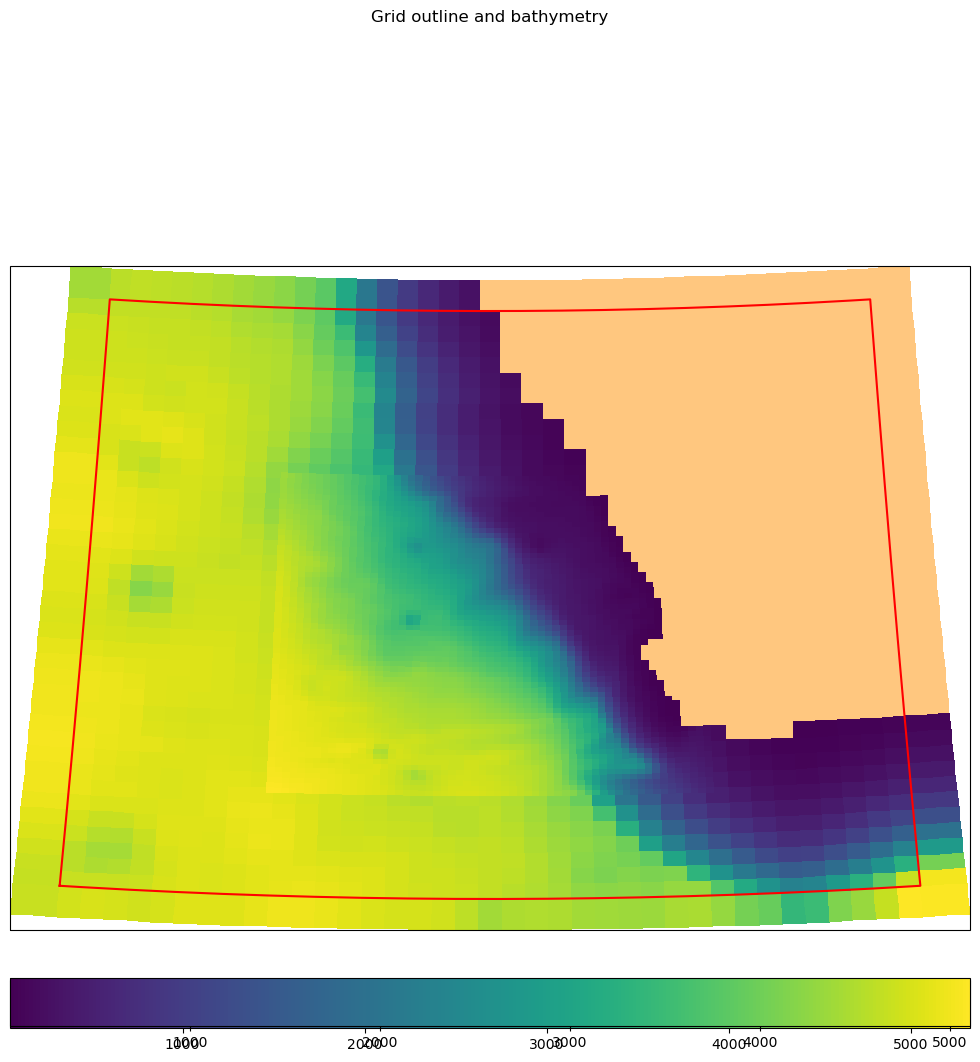

In [71]:
figure2

### Save grid as necdf

This code creates a Netcdf file containing all grid data (geographic, topo-bathymetric, mask) in the format defined by the classes generated earlier in this notebook. Then it saves it in the ouput repertory.

In [27]:
CROCO.create_grid_nc(None,output_file,inputs,outputs)

Writting ../../CROCO_FILES/croco_chd_grd.nc done
